<a href="https://colab.research.google.com/github/Med-Time/BDA-with-PySpark/blob/main/BDA_AAT3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark Session with optimized settings
spark = SparkSession.builder \
    .appName("Optimized Text Mining with PySpark") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .getOrCreate()


In [ ]:
from sklearn.datasets import fetch_20newsgroups

# Load the 20 Newsgroups dataset
categories = None  # Use the full dataset
data = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))

# Create Spark DataFrame
df = spark.createDataFrame([(text,) for text in data.data], ["text"])
df.show(truncate=False, n=5)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

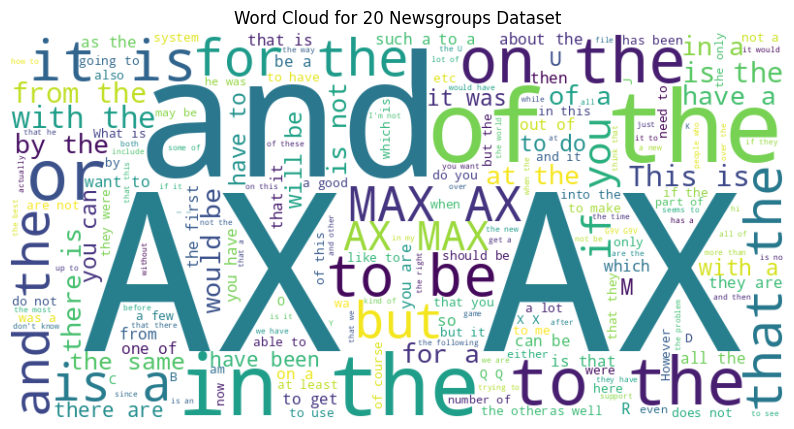

In [ ]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Word Cloud for the entire dataset
text_combined = " ".join(df["text"])
wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords="english").generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for 20 Newsgroups Dataset")
plt.show()

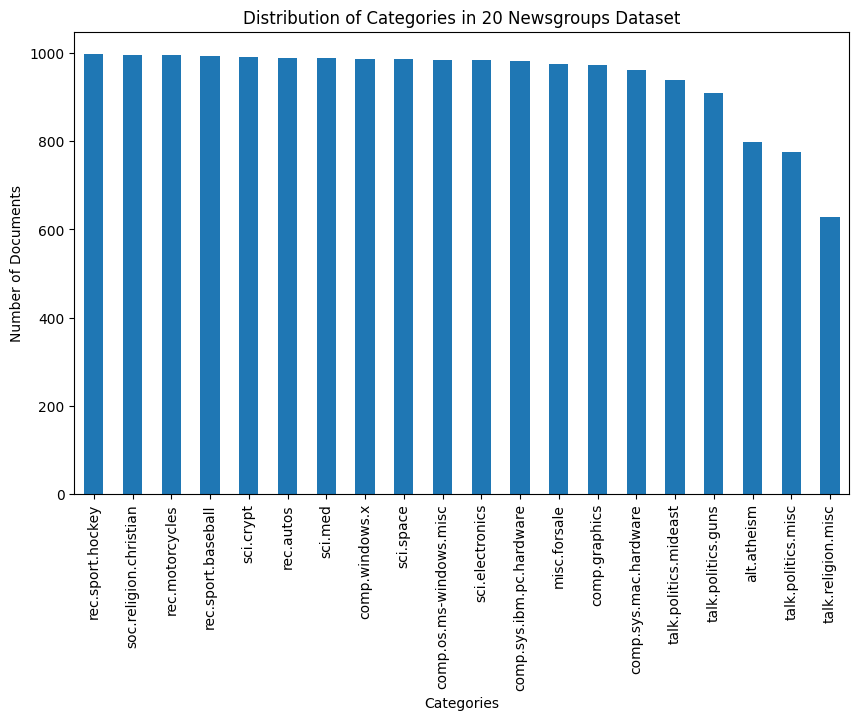

In [ ]:
# Target distribution
plt.figure(figsize=(10, 6))
df["target_names"].value_counts().plot(kind="bar")
plt.title("Distribution of Categories in 20 Newsgroups Dataset")
plt.xlabel("Categories")
plt.ylabel("Number of Documents")
plt.show()

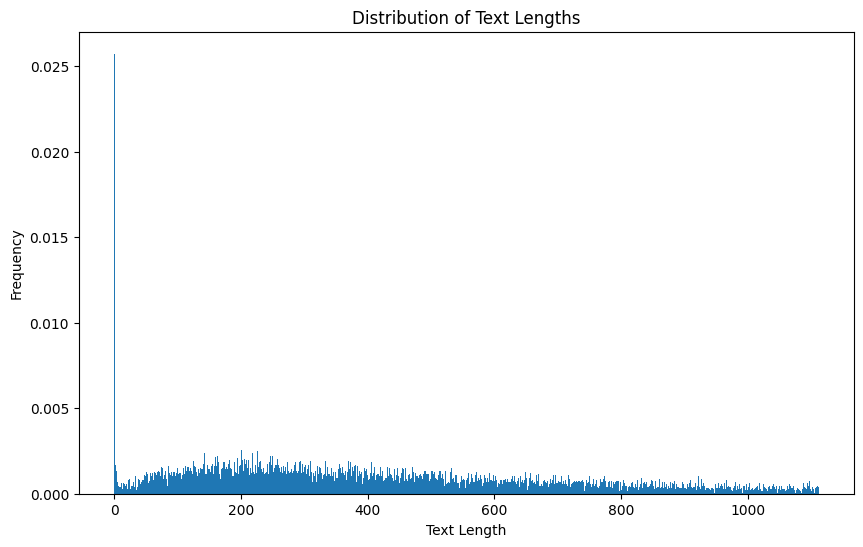

In [ ]:
# Length of text distribution
df["text_length"] = df["text"].apply(len)
plt.figure(figsize=(10, 6))
df["text_length"].plot(kind="hist", bins=1111, range=(0, 1111), density=True)
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Top words in the dataset
vectorizer = CountVectorizer(stop_words="english", max_features=20)
X_counts = vectorizer.fit_transform(data.data)
top_words = pd.DataFrame({"word": vectorizer.get_feature_names_out(), "count": X_counts.sum(axis=0).A1})
print("Top Words in Dataset:")
print(top_words)

Top Words in Dataset:
      word  count
0       ax  62396
1     does   4504
2      don   6524
3      edu   3753
4      god   3399
5     good   3921
6     just   6172
7     know   5763
8     like   6525
9     make   3349
10     max   4637
11     new   4089
12  people   6458
13     say   3015
14   think   5001
15    time   4867
16     use   5027
17    used   3048
18      ve   3143
19     way   3398


In [ ]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Load the 20 Newsgroups dataset
categories = None  # Use all categories
data = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))

# Create a DataFrame for EDA
df = pd.DataFrame({"text": data.data, "target": data.target, "target_names": [data.target_names[t] for t in data.target]})

# Display the first few rows
df.head()

,text,target,target_names
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import re

# Define UDF for text cleaning
def clean_text(text):
    text = re.sub(r'[^a-zA-Z ]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

clean_text_udf = udf(clean_text, StringType())
df = df.withColumn("cleaned_text", clean_text_udf(df["text"]))

# Cache cleaned data
df.cache()


DataFrame[text: string, cleaned_text: string]

In [ ]:
from pyspark.ml.feature import Tokenizer, Word2Vec

# Tokenize the cleaned text into arrays of words
tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="tokens")
tokenized_df = tokenizer.transform(df)

# Train Word2Vec model on the tokenized text
word2vec = Word2Vec(vectorSize=100, minCount=1, inputCol="tokens", outputCol="features")
word2vec_model = word2vec.fit(tokenized_df)
embedded_df = word2vec_model.transform(tokenized_df)

# Cache the embeddings for reuse
embedded_df.cache()


DataFrame[text: string, cleaned_text: string, tokens: array<string>, features: vector]

In [ ]:
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Reduce the dataset size for clustering (adjustable parameter: 50 samples)
sampled_df = embedded_df.limit(18000)  # Reduce this for testing purposes

# Apply PCA for dimensionality reduction
pca = PCA(k=20, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(sampled_df)
reduced_df = pca_model.transform(sampled_df)

# Apply KMeans clustering on the reduced features
kmeans = KMeans(k=20, seed=1, featuresCol="pca_features", predictionCol="cluster", maxIter=10)
kmeans_model = kmeans.fit(reduced_df)
kmeans_result = kmeans_model.transform(reduced_df)

# Evaluate clustering on the sampled dataset
clustering_evaluator = ClusteringEvaluator(predictionCol="cluster")
silhouette_score = clustering_evaluator.evaluate(kmeans_result)
print(f"Silhouette Score for Clustering: {silhouette_score}")


Silhouette Score for Clustering: 0.08477997440736212


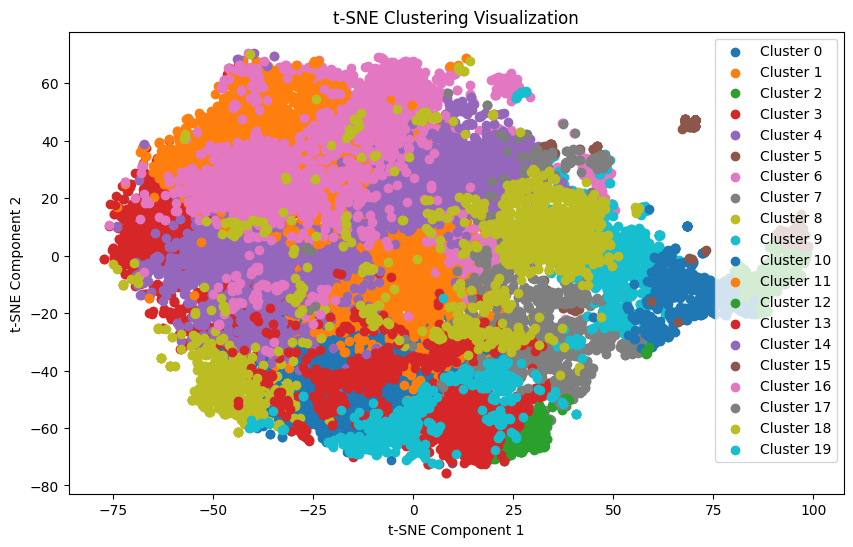

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Extract PCA features and cluster labels for visualization
pca_features = np.array(kmeans_result.select("pca_features").rdd.map(lambda x: x[0]).collect())
cluster_labels = np.array(kmeans_result.select("cluster").rdd.map(lambda x: x[0]).collect())

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_features)

# Plot the t-SNE results
plt.figure(figsize=(10, 6))
for cluster_id in np.unique(cluster_labels):
    cluster_points = tsne_result[cluster_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
plt.legend()
plt.title("t-SNE Clustering Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Add intention labels for classification
def label_text(text):
    if "?" in text or any(word in text for word in ["how", "why", "what"]):
        return "question"
    elif any(word in text for word in ["bad", "problem", "issue"]):
        return "criticism"
    elif any(word in text for word in ["steps", "guide", "process"]):
        return "information"
    else:
        return "opinion"

label_udf = udf(label_text, StringType())
labeled_df = reduced_df.withColumn("intention", label_udf(reduced_df["text"]))

# Index the string labels to numeric values
indexer = StringIndexer(inputCol="intention", outputCol="indexed_intention")
indexed_df = indexer.fit(labeled_df).transform(labeled_df)

# Prepare features for classification
assembler = VectorAssembler(inputCols=["pca_features"], outputCol="assembled_features")
assembled_df = assembler.transform(indexed_df)

# Split the data into training and testing sets
train_df, test_df = assembled_df.randomSplit([0.8, 0.2], seed=42)

# Train Logistic Regression Model
lr = LogisticRegression(featuresCol="assembled_features", labelCol="indexed_intention", predictionCol="prediction")
lr_model = lr.fit(train_df)

# Make predictions
predictions = lr_model.transform(test_df)

# Evaluate classification
evaluator = MulticlassClassificationEvaluator(labelCol="indexed_intention", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Classification Accuracy: {accuracy}")


Classification Accuracy: 0.6645962732919255


In [ ]:
# Save Logistic Regression Model
lr_model.write().overwrite().save("pyspark_lr_model")
print("Model saved")

Model saved


In [ ]:
# Predict the intention of a new text
def predict_intention(text):
    from pyspark.sql import Row

    # Create a single-row DataFrame for the input text
    new_text_df = spark.createDataFrame([Row(cleaned_text=text)])

    # Tokenize the input text (required for Word2Vec)
    tokenized_df = tokenizer.transform(new_text_df)  # Use the tokenizer from Step 4

    # Generate Word2Vec embeddings
    embedding_df = word2vec_model.transform(tokenized_df)

    # Apply PCA for dimensionality reduction
    pca_features_df = pca_model.transform(embedding_df)

    # Add this line to create the 'assembled_features' column
    from pyspark.ml.feature import VectorAssembler
    assembler = VectorAssembler(inputCols=["pca_features"], outputCol="assembled_features")
    pca_features_df = assembler.transform(pca_features_df)

    # Predict intention using the logistic regression model
    prediction = lr_model.transform(pca_features_df)
    predicted_label_index = prediction.select("prediction").collect()[0][0]

    # Convert the numeric prediction back to the original string label
    string_labels = indexer.fit(labeled_df).labels  # Retrieve original string labels
    predicted_label = string_labels[int(predicted_label_index)]

    return predicted_label


In [ ]:
sample_text = "Why is my system crashing during installation?"
predicted_intention = predict_intention(sample_text)
print(f"Predicted Intention: {predicted_intention}")
sample_text1 = "I am Good."
predicted_intention1 = predict_intention(sample_text1)
print(f"Predicted Intention: {predicted_intention1}")

Predicted Intention: question
Predicted Intention: opinion


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Define a UDF to assign intentions based on text
def assign_intention(text):
    if "?" in text or any(word in text.lower() for word in ["how", "why", "what"]):
        return "question"
    elif any(word in text.lower() for word in ["bad", "problem", "issue"]):
        return "criticism"
    elif any(word in text.lower() for word in ["steps", "guide", "process"]):
        return "information"
    else:
        return "opinion"

assign_intention_udf = udf(assign_intention, StringType())

# Add the 'intention' column to the DataFrame
labeled_df = reduced_df.withColumn("intention", assign_intention_udf(reduced_df["text"]))


In [ ]:
from pyspark.ml.feature import StringIndexer

# Label Encoding
label_indexer = StringIndexer(inputCol="intention", outputCol="indexed_label")
indexed_df = label_indexer.fit(labeled_df).transform(labeled_df)


In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train-test Split
train_df, test_df = indexed_df.randomSplit([0.8, 0.2], seed=42)

# Define ANN layers
layers = [
    20,   # Input layer (pca_features have 20 dimensions after PCA)
    1500,
    750,
    200,
    100,
    4# Output layer (number of unique labels)
]

# Train ANN Model
mlp = MultilayerPerceptronClassifier(featuresCol="pca_features", labelCol="indexed_label", predictionCol="prediction",
                                      layers=layers, blockSize=128, maxIter=100, seed=42)
mlp_model = mlp.fit(train_df)

# Evaluate ANN Model
mlp_predictions = mlp_model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="accuracy")
mlp_accuracy = evaluator.evaluate(mlp_predictions)
print(f"ANN Model Accuracy: {mlp_accuracy}")

ANN Model Accuracy: 0.6905702992659515


In [ ]:
# Save ANN Model
mlp_model.write().overwrite().save("pyspark_ann_model")

In [ ]:


from pyspark.ml.classification import MultilayerPerceptronClassificationModel

# Load the saved ANN model
loaded_mlp_model = MultilayerPerceptronClassificationModel.load("pyspark_ann_model")

# Use the loaded model for predictions
new_predictions = loaded_mlp_model.transform(test_df)
#new_predictions.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')